# Predicting processing effort using CCG

This notebook shows how to compute processing effort using [ccgtools](https://github.com/stanojevic/ccgtools) python package. This method was used in papers that predict fMRI brain activity based on the processing effort of predicted by the parser ([paper 1](https://aclanthology.org/2021.cmcl-1.3.pdf) and [paper 2](https://arxiv.org/abs/2210.16147)).

The instructions below show how to compute the predictions using an already parsed sentences (parse tree can come from any CCG parser). ccgtools also have integrated pretrained CCG parsing model for English and Chinese. To use those see the demo notebook in the repository. It requires ccgtools to be installed with a different command than the one presented below.

## Installation

To install the basic parts of ccgtools run the following command:

In [1]:
! pip install -qU "ccgtools@git+https://github.com/stanojevic/ccgtools"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 12.5 MB/s eta 0:00:00


To have visualizations of CCG trees you need to have GraphViz and LaTeX installed. This installation is not needed if you want just the predictions of processing difficulty. To install GraphViz and LaTeX run the following command:

In [2]:
! apt update > /dev/null
! apt install -qq graphviz texlive-latex-extra latex-cjk-all dvipng > /dev/null





Extracting templates from packages: 100%


## Loading trees

To load CCG derivations trees we need only to import DerivationLoader and call from_str function on the string in the CCGbank format. It will return a tree object that can automatically be rendered in Jupyter notebook if LaTeX is installed.

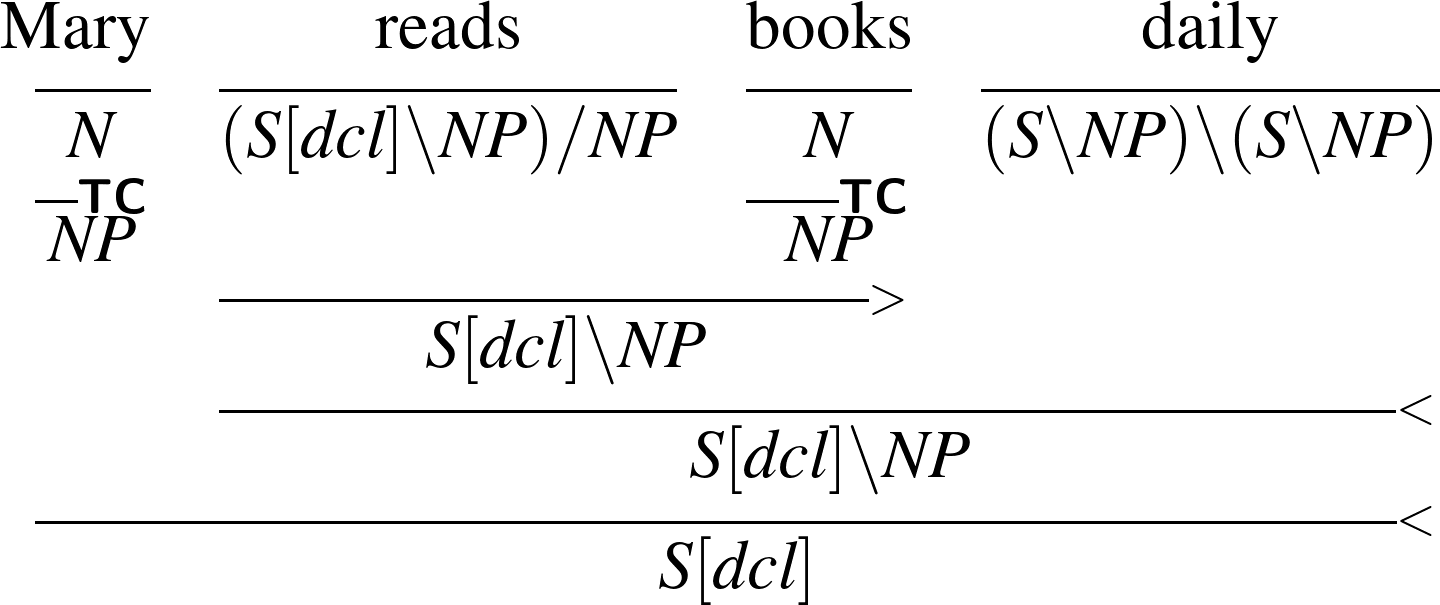

In [3]:
from ccg.derivation import DerivationLoader
tree_str = '(<T S[dcl] 1 2> (<T NP 0 1> (<L N X X Mary N>) ) (<T S[dcl]\\NP 1 2> (<T S[dcl]\\NP 0 2> (<L (S[dcl]\\NP)/NP X X reads (S[dcl]\\NP)/NP>) (<T NP 0 1> (<L N X X books N>) ) ) (<L (S\\NP)\\(S\\NP) X X daily (S\\NP)\\(S\\NP)>) ) )'
tree = DerivationLoader.from_str(tree_str)
tree


## Transforming trees
CCG trees are most often right-branching trees (that holds both for the trees in the CCGbank and those predicted by most CCG parsers). To make sure that the tree is right branching you can call method `tree.to_right_branching()` that will return a new tree that will surely be as right-branching as possible, without changing the semantic interpretation. Similar thing holds for `tree.to_left_branching()`. Revealing operations cannot be expressed with standard CCG trees because revealing is a parsing operation, not an operation of the grammar (i.e. it influences performance, not competence). Still, we can abuse CCG notation and have a special node that signifies where revealing happens, and hold in the meta-information which node what is being revealed. This transformation happens with `tree.to_left_branching_with_revealing()`.

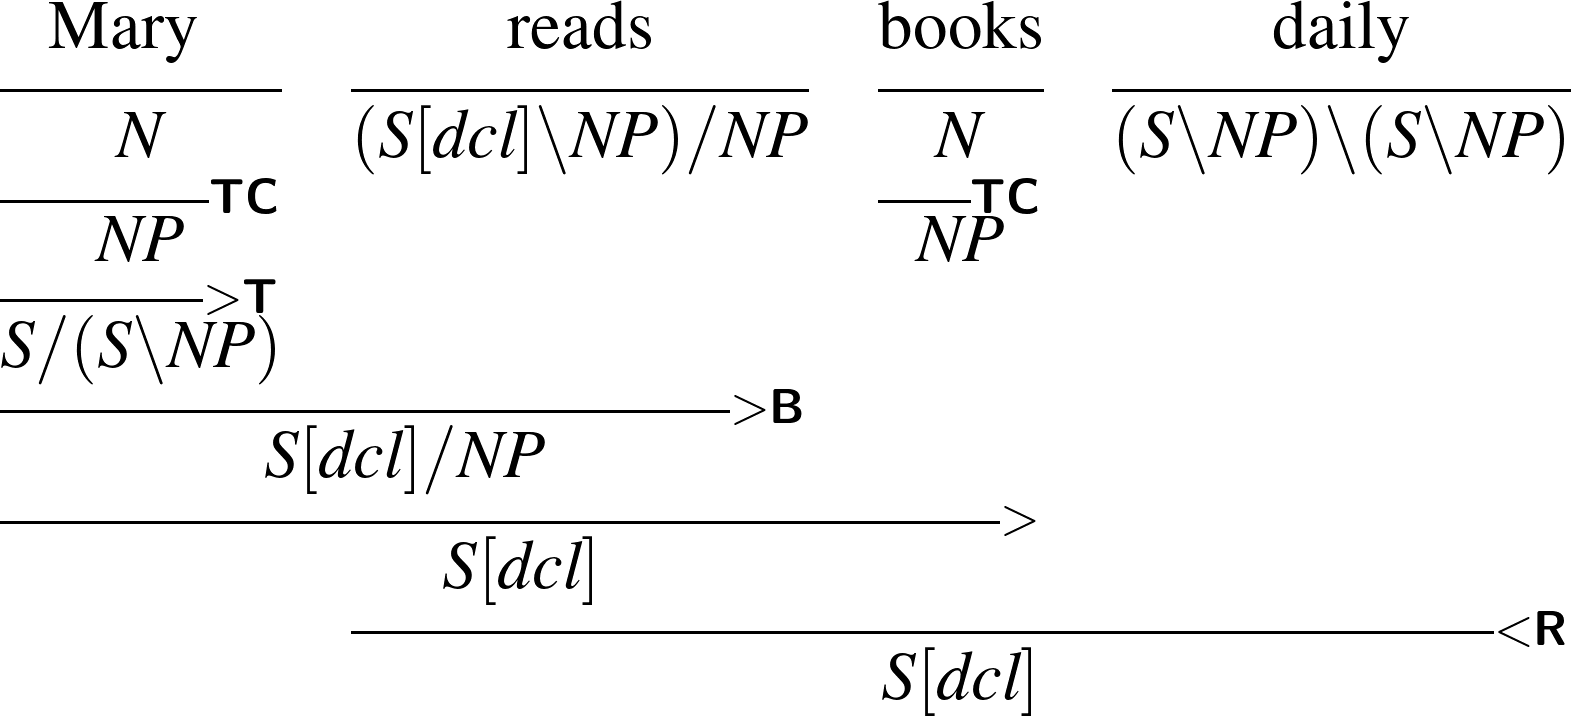

In [4]:
right_branching = tree.to_right_branching()
left_branching = tree.to_left_branching()
left_branching_with_revealing = tree.to_left_branching_with_revealing()

left_branching_with_revealing

## Predicting processing effort

All CCG parsing strategies count the nodes constructed in the bottom-up from each word. For implementation convenience, we can compute the same result with the following top-down function that counts the consecutive right-most edges that lead to each word.

In [5]:
def effort(node, reduces=0):
  if node.children:
    return [c for child in node.children[:-1] for c in effort(child, 0)
            ] + effort(node.children[-1], reduces+1)
  else:
    return [reduces]

This function gives the following predictions for the processing effort per each word:

In [6]:
print(tree.words())
print("Right-branching effort", "\t", effort(right_branching))
print("Left-branching effort", "\t", effort(left_branching))
print("Revealing effort", "\t", effort(left_branching_with_revealing))

['Mary', 'reads', 'books', 'daily']
Right-branching effort 	 [1, 0, 2, 2]
Left-branching effort 	 [1, 0, 2, 2]
Revealing effort 	 [2, 1, 2, 1]


In this case Right- and Left- branching trees give the same result because right-adjunction blocks the tree from becoming more left-branching. To see that the result is different if right-adjunction is not present we can test the same sentence but without right-adjunction:

In [10]:
tree_str = '(<T S[dcl] 1 2> (<T NP 0 1> (<L N X X Mary N>) ) (<T S[dcl]\\NP 0 2> (<L (S[dcl]\\NP)/NP X X reads (S[dcl]\\NP)/NP>) (<T NP 0 1> (<L N X X books N>) ) ) )'
tree = DerivationLoader.from_str(tree_str)
print("Right-branching effort", "\t", effort(tree.to_right_branching()))
print("Left-branching effort", "\t", effort(tree.to_left_branching()))
print("Revealing effort", "\t", effort(tree.to_left_branching_with_revealing()))

Right-branching effort 	 [1, 0, 3]
Left-branching effort 	 [2, 1, 2]
Revealing effort 	 [2, 1, 2]


Here the Left-branching tree gave a different, more incremental prediction, than right-branching tree. Notice that Revealing strategy produced incremental parsing strategy both when right-adjunction was present and when it was not present, while left-branching works incrementally only when there is no right-adjunction.